In [124]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense,LeakyReLU,Conv2D,Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(1)

2 Physical GPUs, 2 Logical GPUs


In [143]:
# ----- DataSet Import ------
(x_train, y_train), (x_test,y_test) = mnist.load_data()

NUM_CLASSES = 10
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
# ----- Feature PreProcessing ----

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32')/ 255.0

# ----- One hot encoding -------
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)

(60000, 28, 28, 1)


In [144]:
def AE(input_shape=(28,28,1)):
    input_layer = Input(shape=input_shape)
    encoder_layer1 = Conv2D(filters=32,kernel_size=3, strides=1,padding='same')(input_layer)
    activation1 = LeakyReLU()(encoder_layer1)
    encoder_layer2 = Conv2D(filters=64,kernel_size=3, strides=2,padding='same')(activation1)
    activation2 = LeakyReLU()(encoder_layer2)
    encoder_layer3 = Conv2D(filters=64,kernel_size=3, strides=2,padding='same')(activation2)
    activation3 = LeakyReLU()(encoder_layer3)
    encoder_layer4 = Conv2D(filters=64,kernel_size=3, strides=1,padding='same')(activation3)
    activation4 = LeakyReLU()(encoder_layer4)
    before_number = K.int_shape(activation4)[1:]
    flatten = Flatten()(activation4)
    encoder_output = Dense(2,activation='relu')(flatten)
    dense_1 = Dense(np.prod(before_number),activation='relu')(encoder_output)
    reshape = Reshape(before_number)(dense_1)
    decoder_conv2d1 = Conv2DTranspose(64,kernel_size=(3,3),strides=1,padding='same')(reshape)
    activation_d1 = LeakyReLU()(decoder_conv2d1)
    decoder_conv2d2 = Conv2DTranspose(64,kernel_size=(3,3),strides=2,padding='same')(activation_d1)
    activation_d2 = LeakyReLU()(decoder_conv2d2)
    decoder_conv2d3 = Conv2DTranspose(32,kernel_size=(3,3),strides=2,padding='same')(activation_d2)
    activation_d3 = LeakyReLU()(decoder_conv2d3)
    decoder_conv2d4 = Conv2DTranspose(1,kernel_size=(3,3),strides=1,padding='same')(activation_d3)
    activation_d4 = LeakyReLU()(decoder_conv2d4)

    model = Model(input_layer,activation_d4)

    return model

In [147]:
vae = AE()
vae.summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_232 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_233 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_234 (LeakyReLU)  (None, 7, 7, 64)          0  

In [148]:
optimizer = Adam(lr = 0.0005)

vae.compile(loss='MSE',optimizer=optimizer, metrics=['accuracy'])

In [149]:
vae.fit(x_train,x_train,batch_size=32,shuffle=True,epochs=20,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 243us/sample - loss: 0.0518 - accuracy: 0.7970 - val_loss: 0.0466 - val_accuracy: 0.7982
Epoch 2/20
60000/60000 [==============================] - 13s 217us/sample - loss: 0.0456 - accuracy: 0.7982 - val_loss: 0.0443 - val_accuracy: 0.7959
Epoch 3/20
60000/60000 [==============================] - 16s 269us/sample - loss: 0.0439 - accuracy: 0.7990 - val_loss: 0.0432 - val_accuracy: 0.8006
Epoch 4/20
60000/60000 [==============================] - 15s 253us/sample - loss: 0.0429 - accuracy: 0.7994 - val_loss: 0.0423 - val_accuracy: 0.7979
Epoch 5/20
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0421 - accuracy: 0.7998 - val_loss: 0.0420 - val_accuracy: 0.7972
Epoch 6/20
60000/60000 [==============================] - 10s 169us/sample - loss: 0.0416 - accuracy: 0.8000 - val_loss: 0.0417 - val_accuracy: 0.7989
Epoch 7/20
60000/60000 [====================

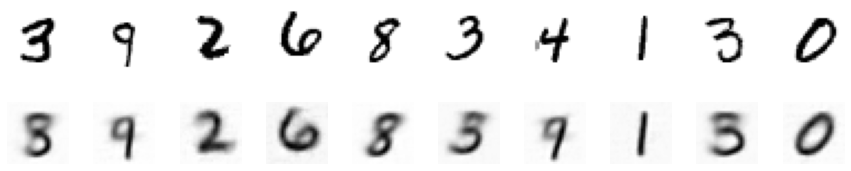

In [150]:
import matplotlib.pyplot as plt

n_to_show = 10
np.random.seed(88)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
reconst_images = vae.predict(example_images)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    # ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')